In [23]:
import os
import math
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

# Kaggle input paths
DATA_ROOT = "/kaggle/input/smart-meters-in-london"
METER_PATH = os.path.join(DATA_ROOT, "daily_dataset.csv")
HH_PATH    = os.path.join(DATA_ROOT, "informations_households.csv")
WEA_PATH   = os.path.join(DATA_ROOT, "weather_hourly_darksky.csv")

print("DATA_ROOT =", DATA_ROOT)
print("METER_CSV =", os.path.exists(METER_PATH), METER_PATH)
print("HOUSEHOLD_INFO_CSV =", os.path.exists(HH_PATH), HH_PATH)
print("WEATHER_CSV =", os.path.exists(WEA_PATH), WEA_PATH)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on:", DEVICE)

DATA_ROOT = /kaggle/input/smart-meters-in-london
METER_CSV = True /kaggle/input/smart-meters-in-london/daily_dataset.csv
HOUSEHOLD_INFO_CSV = True /kaggle/input/smart-meters-in-london/informations_households.csv
WEATHER_CSV = True /kaggle/input/smart-meters-in-london/weather_hourly_darksky.csv
Running on: cuda


In [24]:
# Load meter data
dtype_map = {"LCLid": str}
meter_df = pd.read_csv(METER_PATH, dtype=dtype_map)
if "energy_median" in meter_df.columns:
    meter_df["consumption_kwh"] = meter_df["energy_median"].astype(float)
elif "energy_sum" in meter_df.columns:
    meter_df["consumption_kwh"] = meter_df["energy_sum"].astype(float)
else:
    last_num = meter_df.select_dtypes(include=[np.number]).columns[-1]
    meter_df["consumption_kwh"] = meter_df[last_num].astype(float)

meter_df["timestamp"] = pd.to_datetime(meter_df["day"], utc=True)
meter_df.rename(columns={"LCLid": "household_id"}, inplace=True)
meter_df = meter_df[["timestamp", "household_id", "consumption_kwh"]].sort_values(["household_id", "timestamp"])

# Load household data
hh_info = pd.read_csv(HH_PATH)
hh_info.rename(columns={"LCLid": "household_id"}, inplace=True)

# Load weather data
weather = pd.read_csv(WEA_PATH)
time_col = "time" if "time" in weather.columns else weather.columns[0]
weather["timestamp"] = pd.to_datetime(weather[time_col], utc=True)

# Update column names based on actual data
col_map = {}
for c in weather.columns:
    lc = c.lower()
    if "temp" in lc:
        col_map[c] = "temperature"
    elif "humid" in lc:
        col_map[c] = "humidity"
    elif "windspeed" in lc:  # Fixed column name
        col_map[c] = "wind_speed"  # Ensure consistency with the column name

# Rename columns
weather.rename(columns=col_map, inplace=True)

# Now, check that the columns are properly renamed
print(weather.columns)

# Select only necessary columns
weather = weather[["timestamp", "temperature", "humidity", "wind_speed"]]
weather = weather.set_index("timestamp").sort_index()

# Resample weather data to daily mean and forward fill missing data
weather_d = weather.resample("D").mean().ffill().reset_index()

# Merge weather data with meter data based on timestamp
meter_df["timestamp"] = pd.to_datetime(meter_df["timestamp"], utc=True)
combined_data = pd.merge(meter_df, weather_d, on="timestamp", how="left")

# Filter for household MAC000155
combined_data_mac = combined_data[combined_data["household_id"] == "MAC000155"]

# Show the filtered data for MAC000155
print(combined_data_mac.head())

Index(['visibility', 'windBearing', 'temperature', 'time', 'dewPoint',
       'pressure', 'temperature', 'wind_speed', 'precipType', 'icon',
       'humidity', 'summary', 'timestamp'],
      dtype='object')
                       timestamp household_id  consumption_kwh  temperature  \
115961 2011-11-23 00:00:00+00:00    MAC000155           0.3020     7.442083   
115962 2011-11-24 00:00:00+00:00    MAC000155           0.2220    10.377083   
115963 2011-11-25 00:00:00+00:00    MAC000155           0.2325    10.851667   
115964 2011-11-26 00:00:00+00:00    MAC000155           0.2430    10.227083   
115965 2011-11-27 00:00:00+00:00    MAC000155           0.3095    10.832083   

        temperature  humidity  wind_speed  
115961     6.310417  0.925833    2.281250  
115962     9.589583  0.888333    4.069583  
115963    10.168333  0.790417    5.413333  
115964     9.200000  0.807083    5.770417  
115965    10.350833  0.717083    6.080000  


In [25]:
# Thiết lập hiển thị để Pandas không cắt bớt cột
pd.set_option('display.max_columns', None)

# Hiển thị tất cả cột của dữ liệu đã lọc cho hộ gia đình MAC000155
print(combined_data_mac.head())

                       timestamp household_id  consumption_kwh  temperature  \
115961 2011-11-23 00:00:00+00:00    MAC000155           0.3020     7.442083   
115962 2011-11-24 00:00:00+00:00    MAC000155           0.2220    10.377083   
115963 2011-11-25 00:00:00+00:00    MAC000155           0.2325    10.851667   
115964 2011-11-26 00:00:00+00:00    MAC000155           0.2430    10.227083   
115965 2011-11-27 00:00:00+00:00    MAC000155           0.3095    10.832083   

        temperature  humidity  wind_speed  
115961     6.310417  0.925833    2.281250  
115962     9.589583  0.888333    4.069583  
115963    10.168333  0.790417    5.413333  
115964     9.200000  0.807083    5.770417  
115965    10.350833  0.717083    6.080000  


In [26]:
# Cell04 (Updated: Stacked bidirectional LSTM with past consumption included)
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size, num_layers=2, dropout=0.2, bidirectional=True):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers=num_layers, 
                            batch_first=True, dropout=dropout if num_layers > 1 else 0, 
                            bidirectional=bidirectional)
        hidden_mult = 2 if bidirectional else 1
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(hidden_layer_size * hidden_mult, output_size)

    def forward(self, x):                  # x: (B, T, F)
        out, _ = self.lstm(x)             # (B, T, H * mult)
        out = self.dropout(out)           # Apply dropout to LSTM output
        last = out[:, -1, :]              # (B, H * mult)
        return self.linear(last)          # (B, 1)

# Khởi tạo: số feature đầu vào = 4 (temp, humidity, wind_speed, past_consumption)
input_size = 4
hidden_layer_size = 128  # Effective hidden ~256 with bidirectional
output_size = 1
model = LSTMModel(input_size, hidden_layer_size, output_size).to(DEVICE)
print(model)

LSTMModel(
  (lstm): LSTM(4, 128, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (dropout): Dropout(p=0.2)
  (linear): Linear(in_features=256, out_features=1, bias=True)
)


In [27]:
# ===== Cell 5 (UPDATED: Include past consumption in features, longer seq, denser stride) =====
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler

# 1) Khử trùng tên cột (giữ cột đầu tiên, loại các cột trùng lặp tên)
combined_data_mac = combined_data_mac.loc[:, ~combined_data_mac.columns.duplicated()]

# 2) Chốt danh sách cột feature một cách an toàn
def first_col(df, name):
    idx = np.where(df.columns.values == name)[0]
    if len(idx) == 0:
        raise KeyError(f"Column '{name}' not found after dedup.")
    return df.columns[idx[0]]

temp_col = first_col(combined_data_mac, "temperature")
hum_col  = first_col(combined_data_mac, "humidity")
wind_col = first_col(combined_data_mac, "wind_speed")
cons_col = first_col(combined_data_mac, "consumption_kwh")  # Now use as both feature and target

feat_cols = [temp_col, hum_col, wind_col, cons_col]  # 4 features including past cons
target_idx = 3  # Index of cons in feat_cols

# 3) Tạo mảng numpy với thứ tự [temp, hum, wind, cons]
mac_df = combined_data_mac[feat_cols].dropna().reset_index(drop=True)
mac_arr = mac_df.values.astype(np.float32)    # shape (N, 4)

# 3.1) Normalization: Single scaler for all columns (since cons is shared)
data_scaler = StandardScaler()
scaled_data = data_scaler.fit_transform(mac_arr)  # shape (N, 4), scaled

# 4) Dataset: Now x includes all 4 (weather + past cons)
class EnergyDataset(Dataset):
    def __init__(self, data, seq_length=30, stride=1):  # Longer seq, denser stride
        """
        data: np.array shape (N, 4) = [temp, humid, wind, cons] scaled
        """
        self.data = data
        self.seq_length = seq_length
        self.stride = stride
        self.target_idx = 3
        self.n = len(self.data) - self.seq_length

    def __len__(self):
        if self.n <= 0: return 0
        return 1 + (self.n - 1) // self.stride

    def __getitem__(self, i):
        start = i * self.stride
        window = self.data[start:start+self.seq_length]        # (T, 4)
        x = window[:, :]                                       # (T, 4) <-- all features incl. past cons
        y = self.data[start+self.seq_length, self.target_idx]  # scalar scaled target (next cons)
        return torch.from_numpy(x), torch.tensor(y, dtype=torch.float32)

# 5) Hyper: Longer seq, stride=1 for dense training, adjust batch
SEQ_LEN  = 30
STRIDE   = 1
BATCH_SZ = 64  # Adjust if memory issue

dataset = EnergyDataset(scaled_data, seq_length=SEQ_LEN, stride=STRIDE)

loader_kwargs = dict(batch_size=BATCH_SZ, shuffle=True)
if DEVICE == "cuda":
    loader_kwargs.update(dict(num_workers=2, pin_memory=True))

train_loader = DataLoader(dataset, **loader_kwargs)

# 6) In thông tin xác nhận
x0, y0 = dataset[0]
print("Sample[0] shapes:", x0.shape, y0.shape)    # kỳ vọng: torch.Size([30, 4]) torch.Size([])
print(f"Rows MAC000155: {len(mac_arr)}  | seq_len={SEQ_LEN} stride={STRIDE}  "
      f"-> samples={len(dataset)}  | batch_size={BATCH_SZ}")

Sample[0] shapes: torch.Size([30, 4]) torch.Size([])
Rows MAC000155: 829  | seq_len=30 stride=1  -> samples=799  | batch_size=64


In [28]:
# Updated train_model: More epochs, lower LR for finer convergence
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau

def train_model(model, train_loader, epochs=100, lr=5e-4):  # More epochs, lower LR
    model.train()
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=10, verbose=True)  # Longer patience
    loss_fn = nn.MSELoss()
    if DEVICE == "cuda":
        torch.backends.cudnn.benchmark = True

    # Debug 1 batch
    for xb, yb in train_loader:
        print("DEBUG batch shapes:", xb.shape, yb.shape)  # (B, T, 4), (B,)
        break

    for ep in range(1, epochs+1):
        total, steps = 0.0, 0
        for xb, yb in train_loader:
            xb = xb.to(DEVICE)                # (B, T, 4)
            yb = yb.to(DEVICE).unsqueeze(1)   # (B, 1)

            opt.zero_grad()
            pred = model(xb)                  # (B, 1)
            loss = loss_fn(pred, yb)
            loss.backward()
            opt.step()

            total += loss.item()
            steps += 1

        avg_loss = total / max(steps, 1)
        scheduler.step(avg_loss)

        if ep % 10 == 0 or ep == 1:  # Print every 10 epochs
            print(f"Epoch {ep:02d}/{epochs} | Loss: {avg_loss:.6f}")

# Train with updated params
train_model(model, train_loader, epochs=100, lr=5e-4)

DEBUG batch shapes: torch.Size([64, 30, 4]) torch.Size([64])
Epoch 01/100 | Loss: 0.884991
Epoch 10/100 | Loss: 0.530672
Epoch 20/100 | Loss: 0.506875
Epoch 30/100 | Loss: 0.493619
Epoch 40/100 | Loss: 0.481020
Epoch 50/100 | Loss: 0.447846
Epoch 60/100 | Loss: 0.421933
Epoch 70/100 | Loss: 0.394178
Epoch 80/100 | Loss: 0.377953
Epoch 90/100 | Loss: 0.335583
Epoch 100/100 | Loss: 0.305098


Eval — MSE: 0.001463 | RMSE: 0.038246 | MAE: 0.029138 | Bias: -0.003291


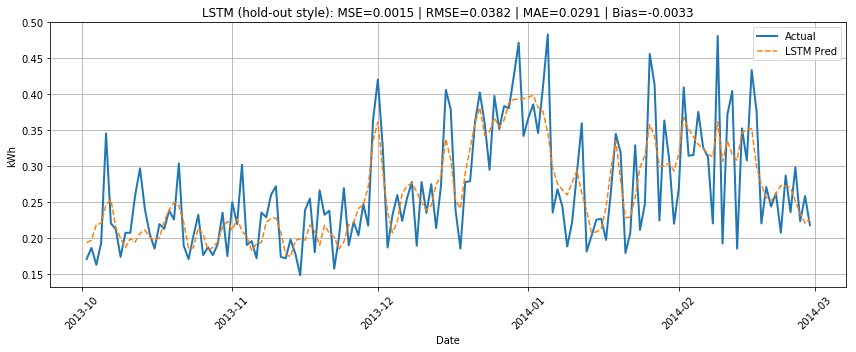

In [29]:
# Updated plotting section: Use data_scaler for inverse transform on cons column
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

model.eval()
with torch.no_grad():
    preds_scaled, targs_scaled, ts_list = [], [], []

    # Tái tạo mảng timestamp
    mac_clean = combined_data_mac.loc[:, ~combined_data_mac.columns.duplicated()].dropna().reset_index(drop=True)
    ts_all = mac_clean["timestamp"].values  # full timestamps

    for i in range(len(dataset)):
        x_i, y_i = dataset[i]
        start = i * STRIDE
        t_idx = start + SEQ_LEN
        if t_idx >= len(ts_all):
            continue

        x_i = x_i.unsqueeze(0).to(DEVICE)  # (1, T, 4)
        p_i = model(x_i).squeeze().detach().cpu().item()
        preds_scaled.append(p_i)
        targs_scaled.append(float(y_i))
        ts_list.append(ts_all[t_idx])

# Inverse transform using scaler params for cons column (index 3)
cons_mean = data_scaler.mean_[3]
cons_scale = data_scaler.scale_[3]
preds = np.array(preds_scaled) * cons_scale + cons_mean
targs = np.array(targs_scaled) * cons_scale + cons_mean

mse  = np.mean((preds - targs)**2)
rmse = sqrt(mse)
mae  = np.mean(np.abs(preds - targs))
bias = float(np.mean(preds - targs))

print(f"Eval — MSE: {mse:.6f} | RMSE: {rmse:.6f} | MAE: {mae:.6f} | Bias: {bias:.6f}")

# Vẽ 150 điểm cuối (dense now with stride=1)
take_last = min(150, len(ts_list))
plt.figure(figsize=(12,5))
plt.plot(ts_list[-take_last:], targs[-take_last:], label="Actual", linewidth=2)
plt.plot(ts_list[-take_last:], preds[-take_last:], label="LSTM Pred", linestyle="--")
plt.title(f"LSTM (hold-out style): MSE={mse:.4f} | RMSE={rmse:.4f} | MAE={mae:.4f} | Bias={bias:.4f}")
plt.xlabel("Date"); plt.ylabel("kWh")
plt.xticks(rotation=45); plt.grid(True); plt.legend()
plt.tight_layout()
plt.show()

Eval — MSE: 0.001463 | RMSE: 0.038246 | MAE: 0.029138 | Bias: -0.003291


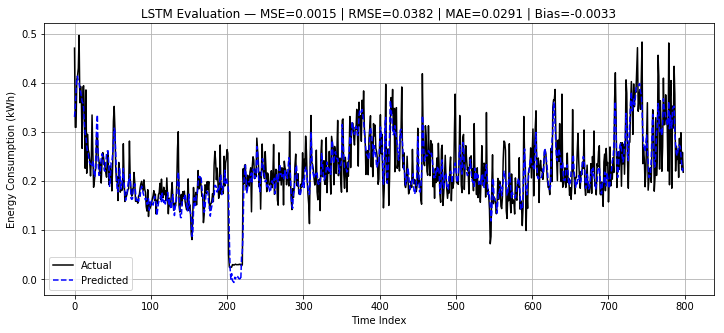

In [30]:
# Updated evaluate_model: Support data_scaler and cons column inverse
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

def evaluate_model(model, dataset, data_scaler, cons_idx=3, seq_length=30):
    model.eval()
    preds_scaled, targs_scaled = [], []

    with torch.no_grad():
        for i in range(len(dataset)):
            x_i, y_i = dataset[i]
            x_i = x_i.unsqueeze(0).to(DEVICE)   # (1, T, 4)
            p_i = model(x_i).squeeze().cpu().item()
            preds_scaled.append(p_i)
            targs_scaled.append(float(y_i))

    # Inverse using scaler params for cons column
    cons_mean = data_scaler.mean_[cons_idx]
    cons_scale = data_scaler.scale_[cons_idx]
    preds = np.array(preds_scaled) * cons_scale + cons_mean
    targs = np.array(targs_scaled) * cons_scale + cons_mean

    mse  = np.mean((preds - targs)**2)
    rmse = sqrt(mse)
    mae  = np.mean(np.abs(preds - targs))
    bias = float(np.mean(preds - targs))

    print(f"Eval — MSE: {mse:.6f} | RMSE: {rmse:.6f} | MAE: {mae:.6f} | Bias: {bias:.6f}")

    # Vẽ biểu đồ Actual vs Predicted (original scale, dense)
    plt.figure(figsize=(12, 5))
    plt.plot(targs, label="Actual", color="black")
    plt.plot(preds, label="Predicted", linestyle="--", color="blue")
    plt.title(f"LSTM Evaluation — MSE={mse:.4f} | RMSE={rmse:.4f} | MAE={mae:.4f} | Bias={bias:.4f}")
    plt.xlabel("Time Index"); plt.ylabel("Energy Consumption (kWh)")
    plt.legend(); plt.grid(True); plt.show()

    return targs, preds

# Run evaluation (pass data_scaler, updated seq_len)
actuals, predictions = evaluate_model(model, dataset, data_scaler, cons_idx=3, seq_length=SEQ_LEN)

In [31]:
# Separate plotting function: Time series with dates
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

def plot_time_series(actuals, predictions, timestamps, title_prefix="LSTM"):
    """
    Plot actual vs predicted in time series format with dates.
    """
    # Ensure lengths match
    min_len = min(len(actuals), len(predictions), len(timestamps))
    actuals = actuals[:min_len]
    predictions = predictions[:min_len]
    timestamps = timestamps[:min_len]

    mse = np.mean((predictions - actuals)**2)
    rmse = sqrt(mse)
    mae = np.mean(np.abs(predictions - actuals))
    bias = float(np.mean(predictions - actuals))

    print(f"Plot Metrics — MSE: {mse:.6f} | RMSE: {rmse:.6f} | MAE: {mae:.6f} | Bias: {bias:.6f}")

    # Plot last 150 points or all if fewer
    take_last = min(150, len(timestamps))
    plt.figure(figsize=(12, 5))
    plt.plot(timestamps[-take_last:], actuals[-take_last:], label="Actual", linewidth=2)
    plt.plot(timestamps[-take_last:], predictions[-take_last:], label="Predicted", linestyle="--")
    plt.title(f"{title_prefix} Time Series — MSE={mse:.4f} | RMSE={rmse:.4f} | MAE={mae:.4f} | Bias={bias:.4f}")
    plt.xlabel("Date"); plt.ylabel("kWh")
    plt.xticks(rotation=45); plt.grid(True); plt.legend()
    plt.tight_layout()
    plt.show()

    return mse, rmse, mae, bias

In [32]:
# Updated evaluate_model: Remove plotting, return also timestamps for separate plot
import numpy as np
from math import sqrt

def evaluate_model(model, dataset, data_scaler, cons_idx=3, seq_length=30):
    model.eval()
    preds_scaled, targs_scaled, ts_list = [], [], []

    # Get timestamps from original data
    mac_clean = combined_data_mac.loc[:, ~combined_data_mac.columns.duplicated()].dropna().reset_index(drop=True)
    ts_all = mac_clean["timestamp"].values

    with torch.no_grad():
        for i in range(len(dataset)):
            x_i, y_i = dataset[i]
            start = i * dataset.stride  # Use dataset.stride
            t_idx = start + seq_length
            if t_idx >= len(ts_all):
                continue

            x_i = x_i.unsqueeze(0).to(DEVICE)
            p_i = model(x_i).squeeze().cpu().item()
            preds_scaled.append(p_i)
            targs_scaled.append(float(y_i))
            ts_list.append(ts_all[t_idx])

    # Inverse transform
    cons_mean = data_scaler.mean_[cons_idx]
    cons_scale = data_scaler.scale_[cons_idx]
    preds = np.array(preds_scaled) * cons_scale + cons_mean
    targs = np.array(targs_scaled) * cons_scale + cons_mean

    mse = np.mean((preds - targs)**2)
    rmse = sqrt(mse)
    mae = np.mean(np.abs(preds - targs))
    bias = float(np.mean(preds - targs))

    print(f"Eval — MSE: {mse:.6f} | RMSE: {rmse:.6f} | MAE: {mae:.6f} | Bias: {bias:.6f}")

    # Plot with time index (kept for quick check)
    plt.figure(figsize=(12, 5))
    plt.plot(targs, label="Actual", color="black")
    plt.plot(preds, label="Predicted", linestyle="--", color="blue")
    plt.title(f"LSTM Evaluation (Index) — MSE={mse:.4f} | RMSE={rmse:.4f} | MAE={mae:.4f} | Bias={bias:.4f}")
    plt.xlabel("Time Index"); plt.ylabel("Energy Consumption (kWh)")
    plt.legend(); plt.grid(True); plt.show()

    return targs, preds, ts_list

Eval — MSE: 0.001463 | RMSE: 0.038246 | MAE: 0.029138 | Bias: -0.003291


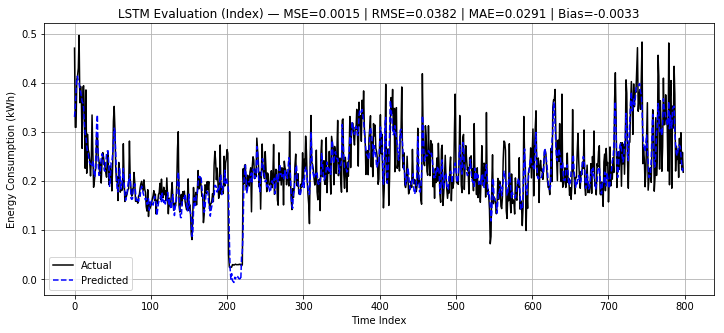

Plot Metrics — MSE: 0.001463 | RMSE: 0.038246 | MAE: 0.029138 | Bias: -0.003291


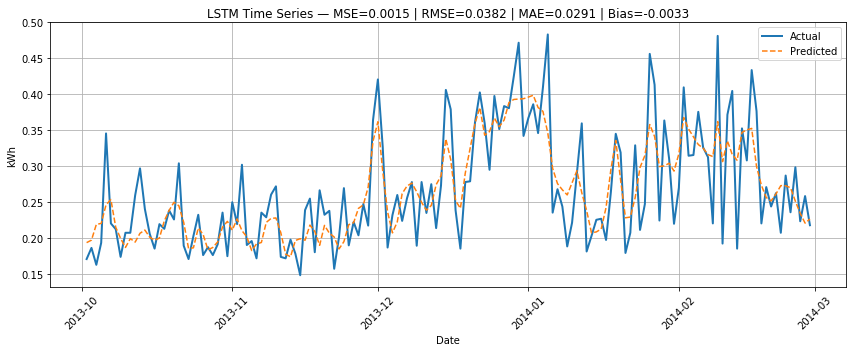

(0.0014627641125924827,
 0.038246099312119176,
 0.02913808156217154,
 -0.0032906021979355314)

In [33]:
# Run evaluation (now returns ts_list too)
actuals, predictions, timestamps = evaluate_model(model, dataset, data_scaler, cons_idx=3, seq_length=SEQ_LEN)

# Separate time series plot with dates
plot_time_series(actuals, predictions, timestamps)

In [34]:
# Updated: Separate plotting functions for index plot and time series plot
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

def plot_index_series(actuals, predictions, title_prefix="LSTM"):
    """
    Separate plot: Actual vs Predicted by time index.
    """
    mse = np.mean((predictions - actuals)**2)
    rmse = sqrt(mse)
    mae = np.mean(np.abs(predictions - actuals))
    bias = float(np.mean(predictions - actuals))

    print(f"Index Plot Metrics — MSE: {mse:.6f} | RMSE: {rmse:.6f} | MAE: {mae:.6f} | Bias: {bias:.6f}")

    plt.figure(figsize=(12, 5))
    plt.plot(actuals, label="Actual", color="black")
    plt.plot(predictions, label="Predicted", linestyle="--", color="blue")
    plt.title(f"{title_prefix} Evaluation (Time Index) — MSE={mse:.4f} | RMSE={rmse:.4f} | MAE={mae:.4f} | Bias={bias:.4f}")
    plt.xlabel("Time Index"); plt.ylabel("Energy Consumption (kWh)")
    plt.legend(); plt.grid(True)
    plt.tight_layout()
    plt.show()  # This will display the plot separately

    # Optional: Save as image
    # plt.savefig('lstm_index_plot.png', dpi=300, bbox_inches='tight')
    # plt.close()

def plot_time_series(actuals, predictions, timestamps, title_prefix="LSTM"):
    """
    Separate plot: Time series with dates.
    """
    # Ensure lengths match
    min_len = min(len(actuals), len(predictions), len(timestamps))
    actuals = actuals[:min_len]
    predictions = predictions[:min_len]
    timestamps = timestamps[:min_len]

    mse = np.mean((predictions - actuals)**2)
    rmse = sqrt(mse)
    mae = np.mean(np.abs(predictions - actuals))
    bias = float(np.mean(predictions - actuals))

    print(f"Time Series Plot Metrics — MSE: {mse:.6f} | RMSE: {rmse:.6f} | MAE: {mae:.6f} | Bias: {bias:.6f}")

    # Plot last 150 points or all if fewer
    take_last = min(150, len(timestamps))
    plt.figure(figsize=(12, 5))
    plt.plot(timestamps[-take_last:], actuals[-take_last:], label="Actual", linewidth=2)
    plt.plot(timestamps[-take_last:], predictions[-take_last:], label="Predicted", linestyle="--")
    plt.title(f"{title_prefix} Time Series — MSE={mse:.4f} | RMSE={rmse:.4f} | MAE={mae:.4f} | Bias={bias:.4f}")
    plt.xlabel("Date"); plt.ylabel("kWh")
    plt.xticks(rotation=45); plt.grid(True); plt.legend()
    plt.tight_layout()
    plt.show()  # This will display the plot separately

    # Optional: Save as image
    # plt.savefig('lstm_time_series_plot.png', dpi=300, bbox_inches='tight')
    # plt.close()

    return mse, rmse, mae, bias

In [35]:
# Updated evaluate_model: Only compute metrics and return data, no plotting
import numpy as np
from math import sqrt

def evaluate_model(model, dataset, data_scaler, cons_idx=3, seq_length=30):
    model.eval()
    preds_scaled, targs_scaled, ts_list = [], [], []

    # Get timestamps from original data
    mac_clean = combined_data_mac.loc[:, ~combined_data_mac.columns.duplicated()].dropna().reset_index(drop=True)
    ts_all = mac_clean["timestamp"].values

    with torch.no_grad():
        for i in range(len(dataset)):
            x_i, y_i = dataset[i]
            start = i * dataset.stride  # Use dataset.stride
            t_idx = start + seq_length
            if t_idx >= len(ts_all):
                continue

            x_i = x_i.unsqueeze(0).to(DEVICE)
            p_i = model(x_i).squeeze().cpu().item()
            preds_scaled.append(p_i)
            targs_scaled.append(float(y_i))
            ts_list.append(ts_all[t_idx])

    # Inverse transform
    cons_mean = data_scaler.mean_[cons_idx]
    cons_scale = data_scaler.scale_[cons_idx]
    preds = np.array(preds_scaled) * cons_scale + cons_mean
    targs = np.array(targs_scaled) * cons_scale + cons_mean

    mse = np.mean((preds - targs)**2)
    rmse = sqrt(mse)
    mae = np.mean(np.abs(preds - targs))
    bias = float(np.mean(preds - targs))

    print(f"Eval — MSE: {mse:.6f} | RMSE: {rmse:.6f} | MAE: {mae:.6f} | Bias: {bias:.6f}")

    return targs, preds, ts_list

Eval — MSE: 0.001463 | RMSE: 0.038246 | MAE: 0.029138 | Bias: -0.003291
Index Plot Metrics — MSE: 0.001463 | RMSE: 0.038246 | MAE: 0.029138 | Bias: -0.003291


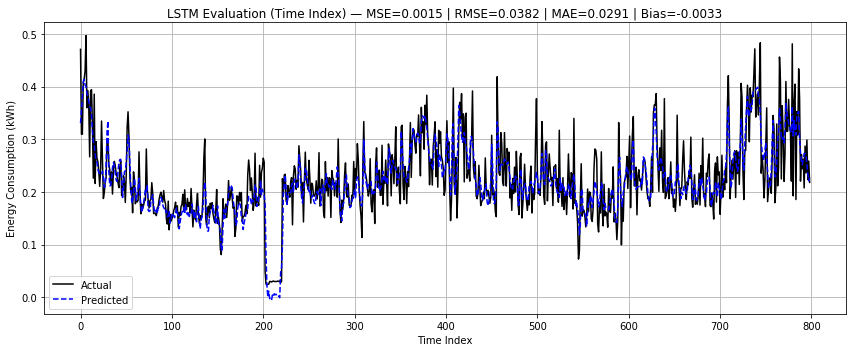

Time Series Plot Metrics — MSE: 0.001463 | RMSE: 0.038246 | MAE: 0.029138 | Bias: -0.003291


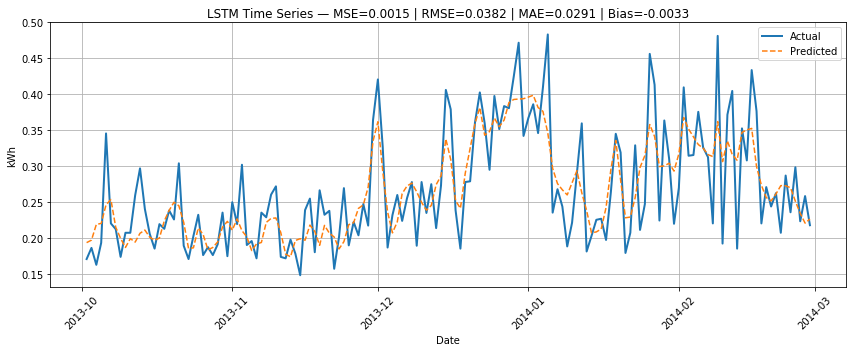

(0.0014627641125924827,
 0.038246099312119176,
 0.02913808156217154,
 -0.0032906021979355314)

In [36]:
# Run evaluation (now no built-in plot)
actuals, predictions, timestamps = evaluate_model(model, dataset, data_scaler, cons_idx=3, seq_length=SEQ_LEN)

# Plot separately: Index plot
plot_index_series(actuals, predictions)

# Plot separately: Time series plot
plot_time_series(actuals, predictions, timestamps)